This notebook explores reading an image to blind user 

The architecture involves 

1. Vision Feature Extractor
2. Vision Transformer Model
3. Custom Decoder
4. Caching Feature Set to PKL file
5. Inference using Greedy Search
6. Inference using Beam Search
7. Text to Speech using gTTS
8. Evaluation using Bleu Score
9. Saving Model Weights to .h5 file   

In [1]:
# Image Captioning with Hugging Face ViT + Custom Decoder

import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
from transformers import ViTFeatureExtractor, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, AdditiveAttention
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import pickle

# Load HF ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Image preprocessing + feature extraction
def extract_features(image_path):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    inputs = feature_extractor(images=img, return_tensors="tf")
    outputs = vit_model(inputs["pixel_values"])
    patch_embeddings = outputs.last_hidden_state[:, 1:, :]  # Remove [CLS] token → shape: [1, 196, 768]
    return tf.squeeze(patch_embeddings, axis=0)  # shape: [196, 768]

# Caption preprocessing
def preprocess_caption(caption):
    return f"<start> {caption.strip()} <end>"

# Decoder model
class CaptionDecoder(Model):
    def __init__(self, vocab_size, embed_dim=256, lstm_units=512):
        super().__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.attention = AdditiveAttention()
        self.lstm = LSTM(lstm_units, return_sequences=True)
        self.fc = Dense(vocab_size)
        self.attn_weights = None
        self.feature_proj = Dense(embed_dim)

    def call(self, features, captions):
        features = self.feature_proj(features)  # [B, 196, embed_dim]
        embedded = self.embedding(captions)     # [B, T, embed_dim]
        context = self.attention([embedded, features],return_attention_scores=True)  # [B, T, embed_dim]
        self.attn_weights = context[1]  # Save for viz
        x = tf.concat([context[0], embedded], axis=-1)
        x = self.lstm(x)
        return self.fc(x)

2025-07-06 14:35:25.795675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751812526.016297      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751812526.075513      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

I0000 00:00:1751812554.899230      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [3]:
# Load Flickr8k dataset from Kaggle path
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
caption_file = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

# Read caption file
df = pd.read_csv(caption_file, delimiter='|')
df.columns = ['image_id', 'comment_number', ' comment']
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x.strip()))

# Use only a subset for demo
image_df = df.iloc[:5000]


In [4]:
img=plt.imread(image_df.iloc[1]['image_path'])
img.shape

(500, 333, 3)

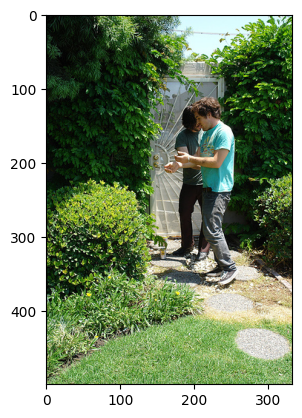

In [5]:
plt.imshow(img)

In [6]:
# Cache features to a dictionary
feature_cache_path = "/kaggle/working/flickr_feature_cache_5k.pkl"
if os.path.exists(feature_cache_path):
    with open(feature_cache_path, "rb") as f:
        cached_features = pickle.load(f)
else:
    cached_features = {}
    for _, row in image_df.iterrows():
        path = row['image_path']
        cached_features[path] = extract_features(path).numpy()
    with open(feature_cache_path, "wb") as f:
        pickle.dump(cached_features, f)

I0000 00:00:1751812592.894897      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [7]:
# Data pipeline
def make_dataset(df, tokenizer, max_len=30, batch_size=32):
    def process(image_path, caption):
        image_path = image_path.numpy().decode()
        caption = caption.numpy().decode()

        features = cached_features[image_path]  # [196, 768]

        cap = preprocess_caption(caption)
        seq = tokenizer.texts_to_sequences([cap])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding='post')[0]

        return features, seq[:-1], seq[1:]

    def tf_wrapper(image_path, caption):
        feat, inp, tgt = tf.py_function(
            func=process,
            inp=[image_path, caption],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        feat.set_shape([196, 768])
        inp.set_shape([max_len - 1])
        tgt.set_shape([max_len - 1])
        return (feat, inp), tgt

    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'], df[' comment']))
    dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
# Tokenizer setup
captions = [preprocess_caption(c) for c in image_df[' comment']]
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(captions)

# Dataset
max_len = 30
train_ds = make_dataset(image_df, tokenizer, max_len=max_len, batch_size=32)

train_ds.cache()

# Model, optimizer, loss
vocab_size = len(tokenizer.word_index) + 1

In [9]:
model = CaptionDecoder(vocab_size=vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [10]:
image_df.head()

,image_id,comment_number,comment,image_path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,/kaggle/input/flickr-image-dataset/flickr30k_i...
1,1000092795.jpg,1,"Two young , White males are outside near many...",/kaggle/input/flickr-image-dataset/flickr30k_i...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr-image-dataset/flickr30k_i...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr-image-dataset/flickr30k_i...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr-image-dataset/flickr30k_i...


In [11]:
def sample_prediction(logits, k=5):
    probs = tf.nn.softmax(logits)
    top_k_probs, top_k_indices = tf.math.top_k(probs, k=k)
    top_k_probs = top_k_probs / tf.reduce_sum(top_k_probs)
    return np.random.choice(top_k_indices.numpy(), p=top_k_probs.numpy())

In [12]:
print("Available GPU:", tf.config.list_physical_devices('GPU'))

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Training loop
EPOCHS = 20
for epoch in range(EPOCHS):
    total_loss = 0
    for (features, inp), tgt in train_ds:
        with tf.GradientTape() as tape:
            preds = model(features, inp)
            loss = loss_fn(tgt, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss += loss.numpy()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 434.7481
Epoch 2, Loss: 327.7144
Epoch 3, Loss: 296.5812
Epoch 4, Loss: 274.3752
Epoch 5, Loss: 253.6894
Epoch 6, Loss: 235.6079
Epoch 7, Loss: 218.0542
Epoch 8, Loss: 201.9281
Epoch 9, Loss: 186.7153
Epoch 10, Loss: 171.4948
Epoch 11, Loss: 157.9595
Epoch 12, Loss: 145.4340
Epoch 13, Loss: 133.7347
Epoch 14, Loss: 123.2941
Epoch 15, Loss: 113.9647
Epoch 16, Loss: 105.2800
Epoch 17, Loss: 97.0637
Epoch 18, Loss: 89.6244
Epoch 19, Loss: 82.4636
Epoch 20, Loss: 76.1093


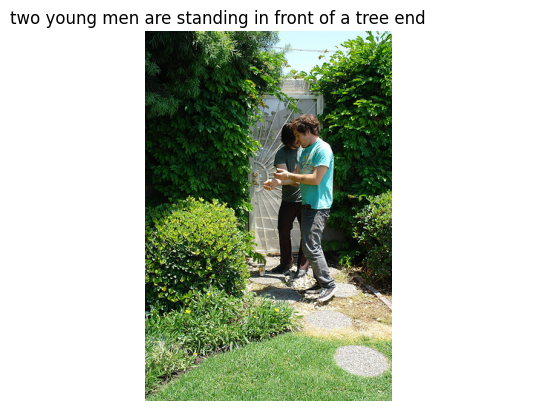

In [14]:
# Inference
index_word = {v: k for k, v in tokenizer.word_index.items()}
def generate_caption(image_path, max_len=30):
    features = extract_features(image_path)
    input_seq = tokenizer.texts_to_sequences(["<start>"])[0]

    for _ in range(max_len):
        seq = pad_sequences([input_seq], maxlen=max_len, padding='post')
        preds = model(tf.expand_dims(features, 0), tf.convert_to_tensor(seq))
        pred_id = tf.argmax(preds[0, len(input_seq)-1]).numpy()
        word = index_word.get(pred_id, '<unk>')
        if word == '<end>':
            break
        input_seq.append(pred_id)

    return ' '.join([index_word.get(i, '') for i in input_seq[1:]])

# Show prediction on a sample image
sample_image_path = image_df.iloc[1]['image_path']
caption = generate_caption(sample_image_path)
img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()

In [15]:
caption

'two young men are standing in front of a tree end                   '

In [16]:
# Attention visualization function
def plot_attention_map(image_path, attention_weights, tokenizer, generated_words):
    img = Image.open(image_path).resize((224, 224))
    fig = plt.figure(figsize=(15, 10))
    len_words = len(generated_words)
    for i in range(len_words):
        ax = fig.add_subplot(round(np.ceil(len_words / 5)), 5, i + 1)
        ax.set_title(generated_words[i])
        attention = attention_weights[0][i]  # shape: [196]
        attention_map = attention.numpy().reshape(14, 14)
        ax.imshow(img)
        ax.imshow(attention_map, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
model.attn_weights.shape

TensorShape([1, 30, 196])

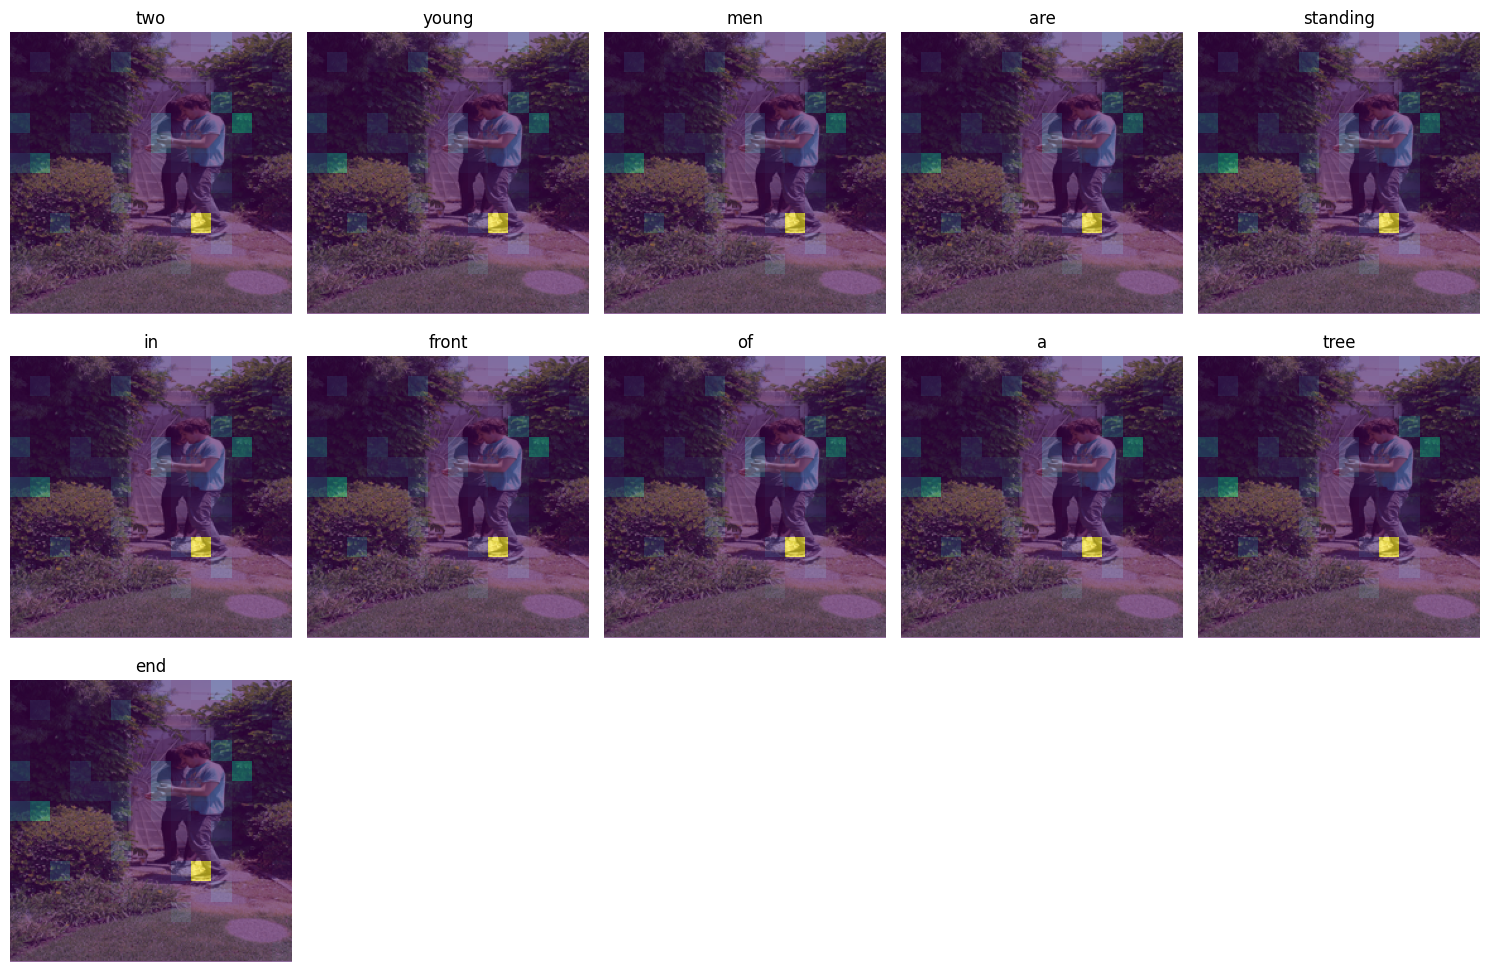

In [18]:
plot_attention_map(image_df.iloc[1]['image_path'], model.attn_weights, tokenizer, caption.split())

In [20]:
pip install gtts

Note: you may need to restart the kernel to use updated packages.


In [21]:
from gtts import gTTS

In [22]:
caption_audio=gTTS(text=caption,lang='en',slow=False)

In [23]:
audio_file_name=image_df.iloc[1]['image_id'].replace(".jpg",".mp3")

In [24]:
caption_audio.save(audio_file_name)

In [25]:
audio_file_name

'1000092795.mp3'

In [ ]:
# Evaluation

In [26]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [27]:
# Evaluate on a few examples using BLEU
smoothie = SmoothingFunction().method4
bleu_scores = []

for i in range(10):  # Evaluate on 10 examples
    row = image_df.iloc[i]
    ref_caption = row[' comment'].strip().lower().split()
    gen_caption = generate_caption(row['image_path']).lower().split()
    score = sentence_bleu([ref_caption], gen_caption, smoothing_function=smoothie)
    bleu_scores.append(score)
    print(f"Image {i+1}: BLEU = {score*100:.2f}%")

print(f"Average BLEU score over 10 samples: {np.mean(bleu_scores)*100:.2f}%")


Image 1: BLEU = 3.33%
Image 2: BLEU = 5.74%
Image 3: BLEU = 13.81%
Image 4: BLEU = 5.74%
Image 5: BLEU = 2.16%
Image 6: BLEU = 1.84%
Image 7: BLEU = 30.93%
Image 8: BLEU = 5.66%
Image 9: BLEU = 3.39%
Image 10: BLEU = 6.32%
Average BLEU score over 10 samples: 7.89%


In [28]:
# inference from beam search

In [29]:
def generate_caption_beam(image_path, beam_width=2, max_len=10):
    features = cached_features[image_path]
    start_seq = tokenizer.texts_to_sequences(["<start>"])[0]
    sequences = [(start_seq, 0.0)]  # (tokens, score)

    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            padded_seq = pad_sequences([seq], maxlen=max_len, padding='post')
            preds = model(tf.expand_dims(features, 0), tf.convert_to_tensor(padded_seq))
            probs = tf.nn.softmax(preds[0, len(seq) - 1]).numpy()

            topk=100
            # Get top beam_width predictions
            top_ids = np.argsort(probs)[-topk:][-beam_width:]
            for word_id in top_ids:
                word = index_word.get(word_id, '<unk>')
                candidate = seq + [word_id]
                candidate_score = score - np.log(probs[word_id] + 1e-9)
                all_candidates.append((candidate, candidate_score))

        # Select beam_width best
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        # Stop if all sequences end
        if all(index_word.get(seq[-1], '') == '<end>' for seq, _ in sequences):
            break

    final_seq = sequences[0][0]
    result = [index_word.get(i, '<unk>') for i in final_seq if index_word.get(i, '') not in ['<start>', '<end>','start','end']]
    return ' '.join(result)



In [30]:
sample_image_path = image_df.iloc[5]['image_path']
beam_caption = generate_caption_beam(sample_image_path)
print("Beam Search Caption:", beam_caption)

Beam Search Caption: three men in hard hats are operating a giant pulley


In [31]:
model

<CaptionDecoder name=caption_decoder, built=True>

In [32]:
model.save_weights('/kaggle/working/caption_decoder.weights.h5')